In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

from tensorflow.keras.models import Sequential, load_model
from pipeline.nn.conv import LeNet
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [2]:
# initialize the list of data and labels
data = []
labels = []

In [3]:
#loop over the input images
# imutils.paths.list_images : grab the image paths and randomly shuffle them
for imagePath in sorted(list(paths.list_images('datasetCNN'))):
    # print(imagePath)
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = imutils.resize(image, width = 28)
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the label list : negative, postive
    label = imagePath.split(os.path.sep)[-2]
    # print(label)

    label = 1 if label == "positives" else 0
    labels.append(label)
# print(labels)

In [13]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype = "float") / 255.0
labels = np.array(labels)
print(labels.shape, data.shape)

(13166,) (13166, 28, 28, 1)


In [5]:
# partition the data into training and testing splits using 80% of the data
# for training and remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size = 0.20, stratify = labels, random_state = 42)

print(trainX.shape)
print(trainY.shape)

(10532, 28, 28, 1)
(10532,)


In [6]:
num_classes = 2


trainY = to_categorical(trainY, num_classes)
testY = to_categorical(testY, num_classes)
print(trainY.shape)
print(testY)

# trainY = trainY.reshape

(10532, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
print(trainX.shape, testX.shape)
print(trainY.shape)
print(testY.shape)

(10532, 28, 28, 1) (2634, 28, 28, 1)
(10532, 2)
(2634, 2)


In [8]:
model = Sequential()
model.add(Conv2D(20, (5, 5), padding = 'same', activation='relu',
    input_shape=(28, 28, 1)))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.3))  

# second set of CONV => RELU => POOL layers
model.add(Conv2D(50, (5, 5), padding = 'same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D(pool_size = (2,2), strides = (2, 2)))
model.add(Dropout(0.3))  

# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(500, activation='relu'))

# softmax classififer
model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        520       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 20)       80        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 20)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        25050     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

2022-06-29 20:11:30.995408: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
opt = keras.optimizers.Adam(learning_rate=0.03)
model.compile(optimizer=opt,loss='categorical_crossentropy' , metrics=['accuracy'])

# model.compile(loss = "categorical_crossentropy", optimizer = "adam",
    # metrics = ["accuracy"])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


In [11]:
mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(trainX, trainY, validation_data = (testX, testY),
    batch_size = 64, epochs = 100, callbacks=[early_stopping, mc], verbose = 1)

Epoch 1/100
165/165 [==============================] - 11s 64ms/step - loss: 4.0962 - accuracy: 0.7174 - val_loss: 0.5706 - val_accuracy: 0.7601
Epoch 2/100
165/165 [==============================] - 11s 65ms/step - loss: 0.4642 - accuracy: 0.7784 - val_loss: 0.4160 - val_accuracy: 0.8257
Epoch 3/100
165/165 [==============================] - 11s 66ms/step - loss: 0.4334 - accuracy: 0.8039 - val_loss: 0.3998 - val_accuracy: 0.8451
Epoch 4/100
165/165 [==============================] - 11s 64ms/step - loss: 0.4146 - accuracy: 0.8138 - val_loss: 0.3852 - val_accuracy: 0.8485
Epoch 5/100
165/165 [==============================] - 11s 67ms/step - loss: 0.4164 - accuracy: 0.8130 - val_loss: 0.4765 - val_accuracy: 0.7878
Epoch 6/100
165/165 [==============================] - 11s 68ms/step - loss: 0.4086 - accuracy: 0.8206 - val_loss: 0.3444 - val_accuracy: 0.8694
Epoch 7/100
165/165 [==============================] - 11s 66ms/step - loss: 0.3694 - accuracy: 0.8441 - val_loss: 0.3075 - val_ac

In [32]:
# save the model to disk
model.save('model/model_cnn_lenet_early_stop4.h5')


In [33]:
loadModel = load_model('model/model_cnn_lenet_early_stop4.h5')

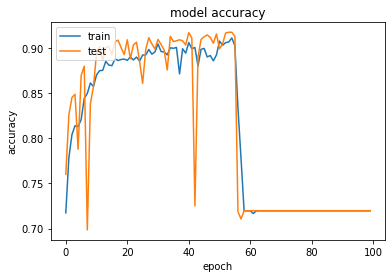

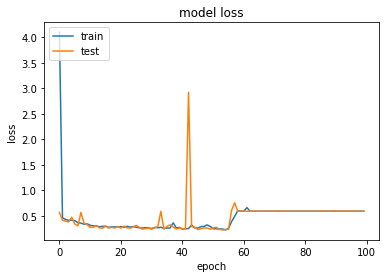

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()